Simulation model 1

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
from cmcrameri import cm as  cmc
import pandas as pd
import xarray as xr

import pdb
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')
from scipy.stats import norm, beta, bernoulli


import ml_estimation as ml
import ml_estimation2 as ml2
import model1_plots as mp
import model1_explore as me
import model1_sim as sim1
import Utilities as util

def createFilename(prop):
    return 'sim_' + '_'.join([f'{x}={prop[x]}' for x in prop])

## parameters from fit

In [50]:
ds = xr.open_dataset('../mod/model2/dH=500_dD=0_5_N=5000local_param.nc')

ds_m1_c = xr.open_dataset('../mod/model1/expl_local_param.nc')
ds_m1_cs= xr.open_dataset('../mod/model1/glob_theta.nc')[['theta1', 'theta3']]

# ds_theta#.theta1, ds_theta.theta3
# ds_localda

In [51]:
ds

<xarray.Dataset>
Dimensions:              (cs_mu_dN: 11, cs_mu_hN: 63, est: 2, method: 2, mu_csf: 5, mu_d: 28, mu_dN: 8, mu_h: 79, mu_hN: 13, n_or_val: 2, var_cod: 2, var_cth_b: 2, var_cth_bm: 5)
Coordinates: (12/13)
  * mu_h                 (mu_h) float64 100.0 300.0 500.0 ... 1.55e+04 1.57e+04
  * mu_d                 (mu_d) float64 -1.0 -0.8 -0.6 -0.4 ... 3.8 4.0 4.2 4.4
  * mu_hN                (mu_hN) float64 -1.5e+03 -1.25e+03 ... 1.25e+03 1.5e+03
  * mu_dN                (mu_dN) float64 -0.8 -0.55 -0.3 -0.05 0.2 0.45 0.7 0.95
  * cs_mu_hN             (cs_mu_hN) float64 250.0 500.0 ... 1.55e+04 1.575e+04
  * cs_mu_dN             (cs_mu_dN) float64 -1.0 -0.5 0.0 0.5 ... 3.0 3.5 4.0
    ...                   ...
  * n_or_val             (n_or_val) object 'val' 'n'
  * method               (method) object 'ML' 'MoM'
  * est                  (est) object 'coef' 'bse'
  * var_cth_bm           (var_cth_bm) object 'mu1' 'nu1' 'mu2' 'nu2' 'p'
  * var_cod              (var_cod) object 'mu' 'sigma'
  * var_cth_b            (var_cth_b) object 'alpha' 'beta'
Data variables:
    p_cs                 (mu_h, mu_d, mu_csf, n_or_val) float64 ...
    param_cod            (mu_h, mu_d, mu_dN, var_cod, n_or_val) float64 ...
    param_cth_bm         (mu_h, mu_d, mu_hN, est, var_cth_bm, n_or_val) float64 ...
    cs_n                 (cs_mu_hN, cs_mu_dN, mu_csf) float64 ...
    cs_p_cs              (mu_csf) float64 ...
    cs_param_cod         (cs_mu_dN, var_cod) float64 ...
    cs_param_cth_bm      (cs_mu_hN, est, var_cth_bm) float64 ...
    cs_csf_param_cod     (var_cod) float64 ...
    cs_csf_param_cth_bm  (est, var_cth_bm) float64 ...

In [52]:
## from cloud 

# p_cs
n_loc = dict(n_or_val = 'n')
n = ds.p_cs.loc[n_loc]


dummy = ds.p_cs.loc[dict(n_or_val = 'val')].where(n > 100)
ds.p_cs.loc[dict(n_or_val = 'val')] = dummy


# cod (mu, sigma)
n_loc = dict(var_cod = 'mu', n_or_val = 'n')
n = ds.param_cod.loc[n_loc]
ds.param_cod.loc[dict(n_or_val = 'val')] = ds.param_cod.loc[
        dict(n_or_val = 'val')].where(n > 100)

#cth ()

n_loc = dict(var_cth_bm = 'mu1', n_or_val = 'n', est = 'coef')
n = ds.param_cth_bm.loc[n_loc]
ds.param_cth_bm.loc[dict(est = 'coef', n_or_val = 'val')] = ds.param_cth_bm.loc[dict(est = 'coef', n_or_val = 'val')].where(
    n > 1000)

ds = ds.loc[dict(n_or_val = 'val')]

# clear sky contains nans as well for cth
n = ds.cs_n.sum(dim = ('cs_mu_dN', 'mu_csf'))
ds.cs_param_cth_bm.loc[dict(est = 'coef')] = ds.cs_param_cth_bm.sel(est = 'coef').where(n > 1000)

# .plot(
#     x ='mu_d', y ='mu_h', col ='mu_dN', col_wrap = 4, cmap = cmc.batlow)


# ds['cs_p_cs'] = ds.cs_p_cs.mean(axis = (0,1))
# ds['cs_param_cod'] = ds.cs_param_cod.mean(axis = (0,2))
# ds['cs_param_cth_bm'] = ds.cs_param_cth_bm.mean(axis = (1,2))
# ds['p_cs'] = ds.p_cs.mean(axis = (2,3)).interpolate_na(
#     dim = 'mu_csf', method = 'zero', fill_value = 'extrapolate')
# ds['param_cod'] = ds.param_cod.mean(axis = (2,4))
# ds['param_cth_bm'] = ds.param_cth_bm.mean(axis = (3,4)).interpolate_na(
#     dim = 'mu_hN', method = 'nearest', fill_value = 'extrapolate')
# ds.cs_param_cth_bm

# ds.n.loc[dict(mu_h = ds.mu_h[0])]


### if not available turn to model 1
# x = (8000, 5)
# model 1
mu_h = np.linspace(0, ml.h_max, 60)
mu_d = np.linspace(-3, 6, 50)
ds1 = sim1.param_c(mu_h, mu_d, ds_m1_c, method = 'nearest')
ds1 = ds1.loc[dict(est = 'coef', method = 'ML')]

# p_cs = sim1.theta_c_to_cs(*x, ds1 , method = 'nearest')
# cth_param = sim1.theta_c_to_c_cth(*x, ds1, method = 'nearest')
# cod_param = sim1.theta_c_to_c_cod(*x, ds1, method = 'nearest')
# p_cs, cth_param, cod_param


In [54]:
theta = ds.cs_param_cth_bm.sel(est = 'coef')
# for var in ds.var_cth_bm:
#     theta.sel(var_cth_bm = var).plot(label = var.data)
#     plt.show()
    
# # plt.legend()
# theta.where(np.isnan(theta.sel(var_cth_bm = 'mu1')), drop = True)


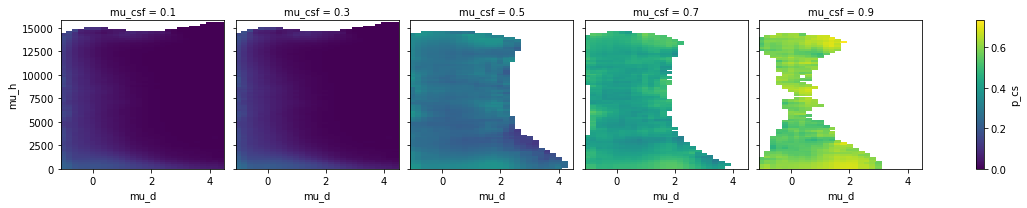

In [55]:
ds.p_cs.plot(col = 'mu_csf')

In [6]:
# ds.p_cs.where(np.isnan(ds.p_cs), drop = True)

# n_loc = dict(n_or_val = 'n')

# n = ds.p_cs.loc[n_loc]

# # ds.p_cs.loc[dict(n_or_val = 'val')].where(n > 100).plot(x ='mu_d', y ='mu_h', col ='mu_csf', col_wrap = 3, cmap = cmc.batlow)

# dummy = ds.p_cs.loc[dict(n_or_val = 'val')].where(n > 100).interpolate_na(
#         dim = 'mu_d', method = 'nearest',
#         fill_value = 'extrapolate'
#         ).interpolate_na(
#         dim = 'mu_h', method = 'nearest', 
#         fill_value = 'extrapolate'
#         )
# ds.p_cs.loc[dict(n_or_val = 'val')] = dummy


# ds.cs_p_cs #ok

# n_loc = dict(var_cod = 'mu', n_or_val = 'n')
# n = ds.param_cod.loc[n_loc]
# ds.param_cod.loc[dict(var_cod = 'mu', n_or_val = 'val')] = ds.param_cod.loc[
#         dict(var_cod = 'mu', n_or_val = 'val')].where(n > 100).interpolate_na(
#         dim = 'mu_h', method = 'nearest',
#         fill_value = 'extrapolate'
#     ).interpolate_na(
#         dim = 'mu_d', method = 'nearest',
#         fill_value = 'extrapolate'
#     )

# ds.param_cod.loc[
#         dict(var_cod = 'sigma', n_or_val = 'val')] = ds.param_cod.loc[
#         dict(var_cod = 'sigma', n_or_val = 'val')].where(n > 100).interpolate_na(
#         dim = 'mu_h', method = 'nearest',
#         fill_value = 'extrapolate'
#     ).interpolate_na(
#         dim = 'mu_d', method = 'nearest',
#         fill_value = 'extrapolate'
#     )

# ds.cs_param_cod # ok

# ds['var_cth_bm'] = ['mu1', 'nu1', 'mu2', 'nu2', 'p']
# n_loc = dict(var_cth_bm = 'mu1', n_or_val = 'n', est = 'coef')
# n = ds.param_cth_bm.loc[n_loc]
# ds.param_cth_bm.loc[dict(est = 'coef', n_or_val = 'val', var_cth_bm = 'mu1')].where(
#     n > 100).plot(
#  x = 'mu_d', y = 'mu_h', col = 'mu_hN', col_wrap = 4, cmap = cmc.batlow)



# # .plot(
# #     x ='mu_d', y ='mu_h', col ='mu_dN', col_wrap = 4, cmap = cmc.batlow)


# # ds['cs_p_cs'] = ds.cs_p_cs.mean(axis = (0,1))
# # ds['cs_param_cod'] = ds.cs_param_cod.mean(axis = (0,2))
# # ds['cs_param_cth_bm'] = ds.cs_param_cth_bm.mean(axis = (1,2))
# # ds['p_cs'] = ds.p_cs.mean(axis = (2,3)).interpolate_na(
# #     dim = 'mu_csf', method = 'zero', fill_value = 'extrapolate')
# # ds['param_cod'] = ds.param_cod.mean(axis = (2,4))
# # ds['param_cth_bm'] = ds.param_cth_bm.mean(axis = (3,4)).interpolate_na(
# #     dim = 'mu_hN', method = 'nearest', fill_value = 'extrapolate')
# # ds.cs_param_cth_bm

# # ds.n.loc[dict(mu_h = ds.mu_h[0])]


In [7]:
# def param_c(h, d, ds_c = ds_c, method = 'linear'):
#     ds_c = ds_c.interpolate_na(dim = 'mu_h', method = method, fill_value = 'extrapolate')
# #     ds_c.interpolate_na(dim = 'mu_d', method = method, fill_value = 'extrapolate')
#     return ds_c.interp(dict(mu_h = h, mu_d=  d), method = method, kwargs={"fill_value": "extrapolate"})

# def theta_c_to_cs(h, d, **kwargs):
#     p = param_c(h,d, **kwargs).p_cs
#     p = toInt(p, [0, 1])
#     return p.data

# def theta_c_to_c_cth(h, d, **kwargs):
#     theta = param_c(h,d, **kwargs)
#     alpha1 = toInt(theta.alpha1.data, [0, np.inf])
#     beta1 = toInt(theta.beta1.data, [0, np.inf])
#     alpha2 = toInt(theta.alpha2.data, [0, np.inf])
#     beta2 = toInt(theta.beta2.data, [0, np.inf])
#     p = toInt(theta.p.data, [0, 1])
#     return (alpha1, beta1, alpha2, beta2, p)

# def theta_c_to_c_cod(h, d, **kwargs):
#     theta = param_c(h,d, **kwargs)
#     mu = theta.mu.data
#     sigma = toInt(theta.sigma.data, [0, np.inf])
#     return (mu, sigma)

# theta_c_to_c_cth( 1.42910614e+04, -9.13208005e-01, method = 'nearest')
# # toInt(5, [9,11])

In [56]:
def get_param(ds, loc, method = 'nearest'): # think more about interpolation method once we have the fll data
#     ds_c.interpolate_na(dim = 'mu_d', method = method, fill_value = 'extrapolate')
    return ds.interp(loc, method = method, kwargs={"fill_value": "extrapolate"})

In [57]:
est = get_param(ds.p_cs, dict(mu_h = 8000, mu_d = 5, mu_csf = .8))
# if np.isnan(est):
    
x = (8000, 5)
# model 1
mu_h = np.linspace(0, ml.h_max, 60)
mu_d = np.linspace(-3, 6, 50)
ds1 = sim1.param_c(mu_h, mu_d, ds_m1_c, method = 'nearest')
ds1 = ds1.loc[dict(est = 'coef', method = 'ML')]

p_cs = sim1.theta_c_to_cs(*x, ds1 , method = 'nearest')
cth_param = sim1.theta_c_to_c_cth(*x, ds1, method = 'nearest')
cod_param = sim1.theta_c_to_c_cod(*x, ds1, method = 'nearest')
p_cs, cth_param, cod_param
np.isnan(p_cs)

False

In [10]:
# mu_h = np.linspace(ds_c.mu_h.min(), ds_c.mu_h.max(), 60)
# mu_d = np.linspace(ds_c.mu_d.min(), ds_c.mu_d.max(), 50)
# ds = param_c(mu_h, mu_d)

# mu_h = np.linspace(0, ml.h_max, 60)
# mu_d = np.linspace(-3, 6, 50)
# n_h, n_d = len(mu_h), len(mu_d)

# ds = ds_c.interpolate_na(dim = 'mu_h', method = 'nearest', fill_value = 'extrapolate')

# ds = param_c(mu_h, mu_d, ds_c = ds, method = 'nearest')
# # ds = ds_c

# fig, ax = plt.subplots(4,3, figsize = (15, 20))
# fig.subplots_adjust(hspace=.3)
# fig.subplots_adjust(wspace=.3)
# axs = ax.flatten()
# for i, var in zip(range(12),list(ds.keys())):
#     if 'nu' in var:
#         im = ds[var].plot(ax = axs[i], cmap = cm.Blues, norm = mpl.colors.LogNorm())
#     else:
#         im = ds[var].plot(ax = axs[i], cmap = cm.Blues)
#     axs[i].set(title = var)

# ds.p_cs.where(np.isnan(ds_c.p_cs) , drop = True)

In [90]:
10 - np.nan

nan

In [91]:
def step_pixel(z, h, d, csf, h_bar, d_bar, ds):
    """Makes one step.
    Args:
        x (np.array(6,)):                
            current full state Y of the pixel (z, h, d, csf, h_bar, d_bar)
        ds xarray with parameter estimates
    Returns:
        np.array (3,): updated state of the pixel (z, h, d)
    """

    
    ## p_cs
    if z: 
        loc = dict(mu_csf = csf)
        p_cs = get_param(ds.cs_p_cs, loc)
    else: 
        loc = dict(mu_h = h, mu_d = d, mu_csf = csf)
        p_cs = get_param(ds.p_cs, loc)
        h_bar = h_bar - h
        d_bar = d_bar - d
        
    if np.isnan(p_cs):
        p_cs = sim1.theta_c_to_cs(h, d, ds1 , method = 'nearest')
        print(f'p_cs from model1 for (z, h, d, csf) = {(z, h, d, csf)}')
        
    
#     print('x and p_cs', x, p_cs)
    
    # to cloud or clear sky
    z_next = bernoulli.rvs(p_cs)
    
    if z_next: # if there is a cloud (h, d)next are not defined
        h_next, d_next = np.nan, np.nan
    else:     
        if z: 
            if csf: ## x current is a clear sky and is only surrounded by cs
            # then h_bar and d_bar ar NaN
            # TODO: fit
                cod_param = ds.cs_csf_param_cod.data
                cth_param = ds.cs_csf_param_cth_bm.sel(est = 'coef').data
            else:

                loc = dict(cs_mu_dN = d_bar)
                cod_param = get_param(ds.cs_param_cod, loc).data
                loc = dict(cs_mu_hN = h_bar)
                cth_param = get_param(ds.cs_param_cth_bm.loc[dict(est = 'coef')], loc).data
#             pdb.set_trace()
        else: ## x is cloud:
            loc = dict(mu_h = h, mu_d = d, mu_dN = d_bar)
            cod_param = get_param(ds.param_cod, loc).data
            loc = dict(mu_h = h, mu_d = d, mu_hN = h_bar)
            cth_param = get_param(ds.param_cth_bm.loc[dict(est = 'coef')], loc).data
        
        if np.isnan(cod_param).any():
            cod_param = sim1.theta_c_to_c_cod(h, d, ds1, method = 'nearest')
            print(f'p_cs from model1 for (z, h, d, d_bar) = {(z, h, d, d_bar)}')

            
#         print(cod_param.data, cth_param.data)
        mu, sigma = cod_param
        alpha1, beta1, alpha2, beta2, p = ml2.mixmnToab(*cth_param.data)
        
#         print(mu, sigma)
        d_next = (np.random.randn(1) * sigma + mu) 
        
#         print(cth_param)
#         import pdb; pdb.set_trace()
        if np.isnan(cth_param).any():
#             print(h, d)
            if z:
                h, d = 0, -1  ### todo delete if statement if cs_param_cth is correct
            cth_param = sim1.theta_c_to_c_cth(h, d, ds1, method = 'nearest')
            print(f'cth_param from model1 for (z, h, d, h_bar) = {(z, h, d, h_bar)}')
            alpha1, beta1, alpha2, beta2, p = cth_param

#         print(cth_param)
        x = np.random.rand(1)
        y1 = beta.rvs(alpha1, beta1)
        if p == 1:
            h_next = y1
        else:
            y2 = beta.rvs(alpha2, beta2)
            u = (x < p)
        #     print('u, y1, y2', u, y1 ,y2)
            h_next = ml.UnitInttoCTH(u * y1 + ~u * y2)
    
    
    return np.hstack([z_next, h_next, d_next])

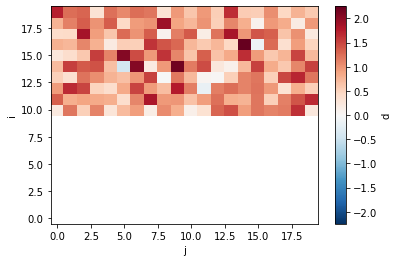

<xarray.Dataset>
Dimensions:  (i: 20, j: 20)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    h        (i, j) float64 nan nan nan nan ... 2.114e+03 2.147e+03 2.085e+03
    d        (i, j) float64 nan nan nan nan nan ... 1.037 0.4615 0.7877 0.585
    z        (i, j) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [95]:
N, M = 20, 20
np.random.seed(0)
X0 = None

X0 = xr.Dataset(
    data_vars=dict(
        h = (['i', 'j'], np.random.randn(int(N), M)*100 + 2000), 
        d = (['i', 'j'], np.random.randn(N, M)/2 + 1), 
        z = (['i', 'j'], np.zeros((N,M))), 
    ),
    coords=dict(
        i = np.arange(N),
        j = np.arange(M)
    ),
    # attrs=dict(dh = dh, dd = dd
    # ),
    )

X0.z[:N//2, :] = 1
X0['h'] = X0.h.where(X0.z == 0)
X0['d'] = X0.d.where(X0.z == 0)
X0.d.plot()
plt.show()
X_next = None
X0

In [73]:
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [74]:
def neighborhood(ds, i, j,
                 n = 1 # neighbor degree
                 ):

    xlow = max(0, i - n)
    xupper = min(ds.dims['i'], i + n + 1)
    
    ylow = max(0, j - n)
    yupper = min(ds.dims['j'], j + n + 1)
    
    N = (slice(xlow, xupper, 1), slice(ylow, yupper, 1))
    
    return N

In [96]:
### simulation
import itertools

X = X0.copy(deep = True)
T = 5
t = 0
for t in range(T):
    print(f't = {t}', end = '\r')
    if t == 0 :
        Xt = X0.copy(deep = True)
    else:
        Xt = X.sel(t = t)
    X_next = X0.copy(deep = True)
    for i, j in itertools.product(Xt.i.data, Xt.j.data):
        N = neighborhood(Xt, i, j)
        pix = dict(i = i, j = j)
        y = [Xt.z[pix], Xt.h[pix], Xt.d[pix], 
             Xt.z[N].mean(), Xt.h[N].mean(), Xt.d[N].mean()]
    #     print(pix)
    #     print(y)
        y = np.array([yi.data for yi in y])
    #     print('y = ', y)
#         print('x = ', y[:3])
        x_next = step_pixel(*y, ds)
#         print('x_n =',x_next)
        X_next.z.loc[pix] = x_next[0]
        X_next.h.loc[pix] = x_next[1]
        X_next.d.loc[pix] = x_next[2]
    #     X_next.loc[pix]
    X_next['t'] = t+1
    X = xr.concat([X, X_next], dim = 't')
    X_next = None

    

p_cs from model1 for (z, h, d, csf) = (0.0, 8895.35291245754, -0.32568008712817365, 0.8888888888888888)
p_cs from model1 for (z, h, d, csf) = (0.0, 14850.344478622357, 1.042703776200137, 0.7777777777777778)
p_cs from model1 for (z, h, d, d_bar) = (0.0, 14850.344478622357, 1.042703776200137, -0.2216436415724442)
cth_param from model1 for (z, h, d, h_bar) = (0.0, 14850.344478622357, 1.042703776200137, -2341.3539346979396)
cth_param from model1 for (z, h, d, h_bar) = (0.0, 2988.031765742834, -0.5209176288372952, -1882.066109741398)
p_cs from model1 for (z, h, d, csf) = (0.0, 10464.185371405332, 1.3178751659382715, 0.8888888888888888)
cth_param from model1 for (z, h, d, h_bar) = (0.0, 2945.8106290221544, 1.2894088370477224, -1518.237231739779)
cth_param from model1 for (z, h, d, h_bar) = (0.0, 4798.513179070359, 1.803357200927889, -2961.2956672279024)
cth_param from model1 for (z, h, d, h_bar) = (0.0, 4009.5281889493776, -0.4020242278948437, -1522.648666789608)
cth_param from model1 for (z

In [15]:
# df = pd.DataFrame(x, columns = ['h_t', 'd_t'])
# df['cloud'] = df.apply(lambda x : 'cloud' if ~np.isnan(x.h_t) else 'clear sky', axis = 1)
# dqf = df.cloud.apply(lambda x : 6 if x == 'clear sky' else 0)
# df['ISCCP'] = util.classifyISCCP(df.d_t, df.h_t, dqf , bound = [np.log(3.6), np.log(23), 2e3, 8e3]).astype(int)

# df = df.append({'h_t' : np.nan, 'd_t' : np.nan}, ignore_index = True)
# df['h_t_next'] = np.roll(df.h_t, -1)
# df['d_t_next'] = np.roll(df.d_t, -1)
# df['cloud_next'] = np.roll(df.cloud, -1)
# df['ISCCP_next'] =  np.roll(df.ISCCP, -1)
# df.to_csv(f'../data/simulation/model1/sim_n={len(df) - 1}.csv')
# df

ValueError: Shape of passed values is (2, 1), indices imply (2, 2)

In [100]:
def rgb(z, h, d, c = .92):
    light_blue = (173/255, 216/255, 230/255)
    if z:
        return (1,1,1)
    else: 
        h_, d_ = ml.CTHtoUnitInt(h), sim1.toInt((d + 1)/5, [0, 1])
        color = (            
            (h_) * c, 
            (-d_ + 1) * c  , 
            (-d_ + h_ + 1) * 0 + .8)
        return color
rgb(0, 1000, 4)


X['RGB'] = (['i', 'j','t', 'color'], np.zeros((20,20, len(X.t), 3)))
ds['RGB_colorbar'] = (['mu_h', 'mu_d', 'color'], np.zeros((len(ds.mu_h),len(ds.mu_d), 3)))

for i, j, t in itertools.product(X.i.data, X.j.data, X.t.data):
    pix = X.sel(i = i, j = j, t = t)
#     print( data.RGB.loc[dict(i = i , j = j)])
    X.RGB.loc[dict(i = i , j = j, t = t)] = np.array(rgb(pix.z.data, pix.h.data, pix.d.data))

for h, d in itertools.product(ds.mu_h, ds.mu_d):
#     print( data.RGB.loc[dict(i = i , j = j)])
#     print(h)
    ds.RGB_colorbar.loc[dict(mu_d = d, mu_h = h)] = np.array(rgb(0, h.data, d.data))
    

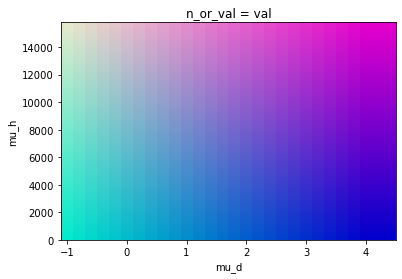

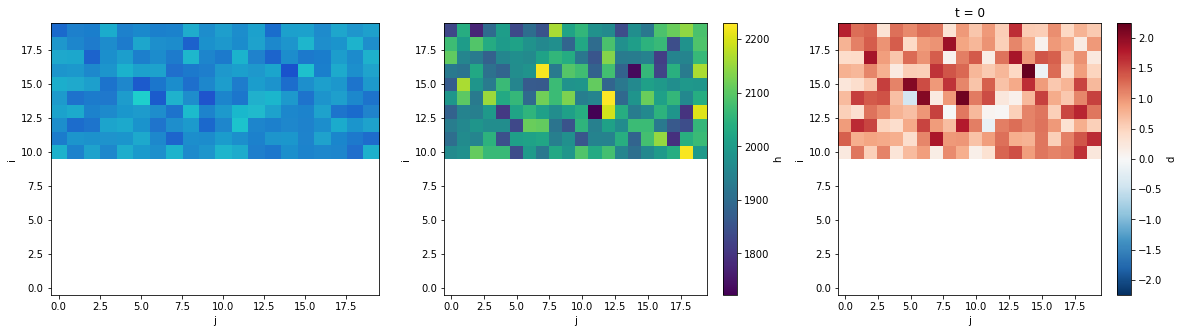

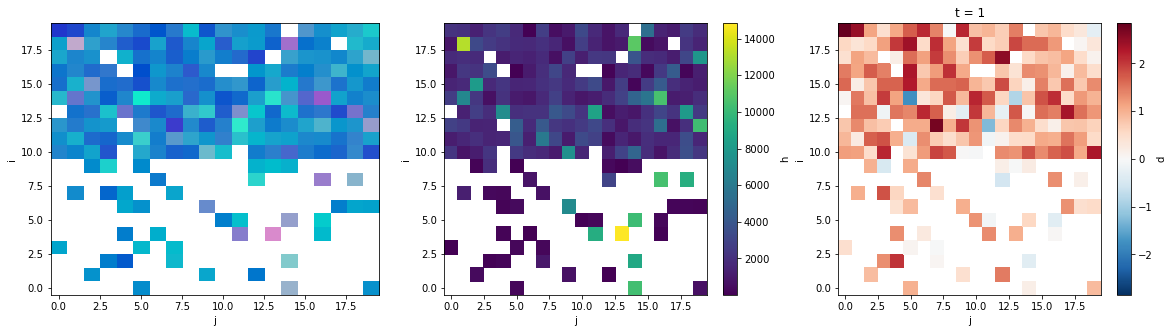

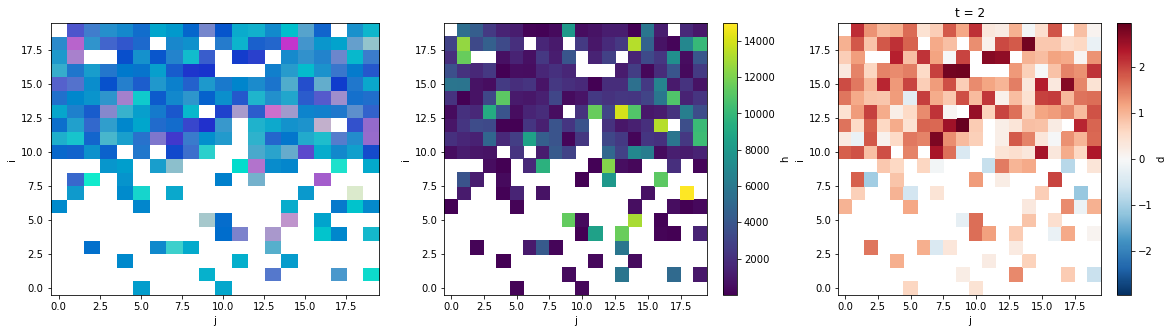

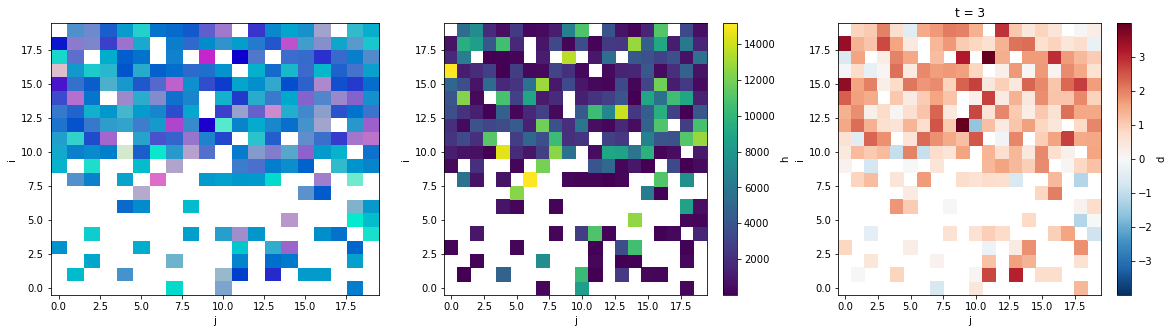

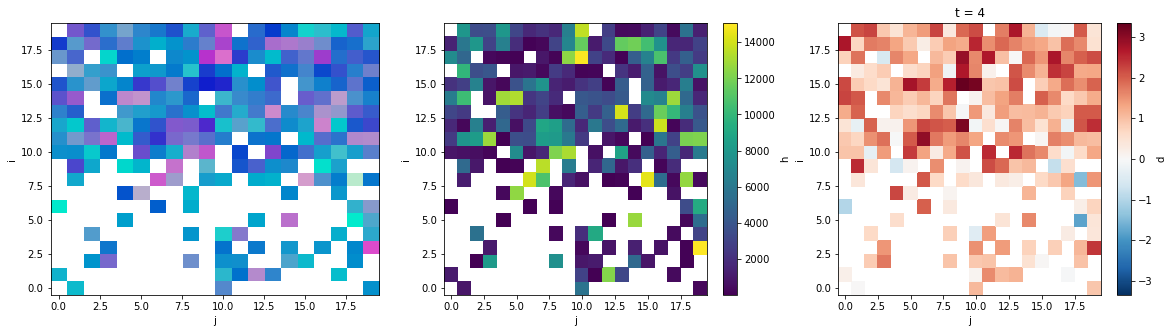

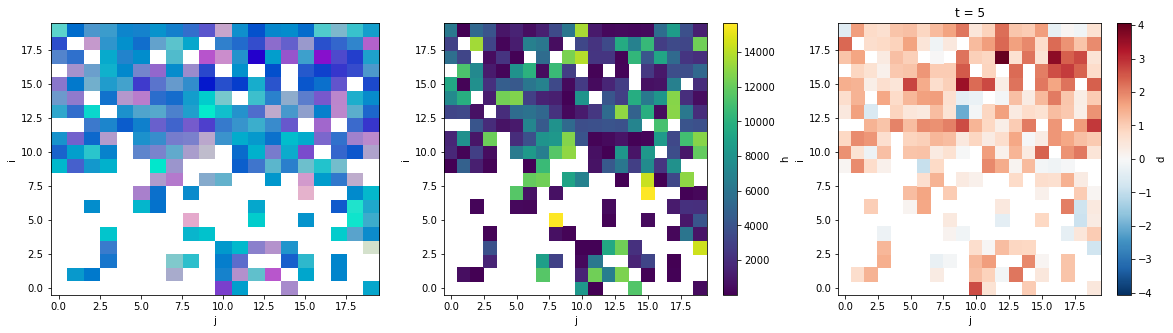

In [109]:
xr.plot.imshow(ds.RGB_colorbar)
plt.show()

for t in X.t.data:
    fig, ax = plt.subplots(1,3, figsize = (20, 5))
    xr.plot.imshow(X.loc[dict(t = t)].RGB, ax = ax[0])
    X.sel(t = t).h.plot(ax = ax[1])
    X.sel(t = t).d.plot(ax = ax[2]) 
    plt.title(f't = {t}')
    plt.savefig(f'sim_model2_0={t}.png')
    plt.show()
    
    
